<a href="https://colab.research.google.com/github/pjcroxas/Data-Analytics-Case-Studies/blob/main/CO2_Emission_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [28]:
# Read Dataset
dirs = "/content/drive/My Drive/Data Science Portfolio/CO2 Forecasting/CO2 Emission/data"

# Primary Dataset
train = pd.read_csv(dirs+"/train.csv")
test_target = pd.read_csv(dirs+"/test_target.csv") # With label
test = pd.read_csv(dirs+"/test.csv") # without label

# Secondary Datasets
gdp = pd.read_csv(dirs+"/gdp.csv")
population = pd.read_csv(dirs+"/population.csv")
vehicle_sales = pd.read_csv(dirs+"/vehicle_sales.csv")

# **Check Dataset**
**Primary data**

In [8]:
train.sample(3)

,year,month,source,fuel_type,emissions_tons
2195,2008,12,industry,natural_gas,763.87
800,2018,9,industry,oil,1217.79
1757,2007,6,transport,natural_gas,37.50


In [9]:
test_target.sample(3)

,year,month,source,fuel_type,emissions_tons
31,2022,8,other,oil,1134.95
7,2022,8,transport,oil,6276.48
12,2022,1,industry,oil,1079.66


In [10]:
test.sample(3)

,year,month,source,fuel_type
7,2022,8,transport,oil
16,2022,5,industry,oil
12,2022,1,industry,oil


**Secondary data**

The secondary data are essential in the modeling part. We will need to join these (3) datasets to the training, test target, and test set, in order to fully utilize the prediction capability of the model.

In [11]:
gdp.sample(3)

,Year,Quarter,GDP_(current_mkt_value),GDP_(ref_year=2002)
54,2006,Q3,2074685.0,1746759.000
84,2014,Q1,3322196.0,2386444.034
26,1999,Q3,1182199.0,1246015.000


In [16]:
gdp.Quarter.value_counts()

Quarter
Q1    30
Q2    30
Q3    30
Q4    30
Name: count, dtype: int64

In [12]:
population.sample(3)

,Year,Population
23,2016,65931550
20,2013,64785909
2,1995,59460382


In [13]:
vehicle_sales.sample(3)

,year,passenger,commercial,motorcycle,total
14,2000,83127,179126,796292,1058545
19,2005,185761,517677,2053000,2756438
33,2019,432760,524906,1675555,2633221


# **Data Processing**

In [33]:
def create_quarter(feature):
  if feature in (1, 2, 3):
    return "Q1"
  elif feature in (4, 5, 6):
    return "Q2"
  elif feature in (7, 8, 9):
    return "Q3"
  elif feature in (10, 11, 12):
    return "Q4"
  else:
    pass

train["Quarter"] = train["month"].apply(create_quarter)
test_target["Quarter"] = test_target["month"].apply(create_quarter)
test["Quarter"] = test["month"].apply(create_quarter)

In [34]:
def join_secondary_data(gdp, pop, sales, main):
  gdp = gdp.rename(columns=lambda x: x.lower())
  pop = pop.rename(columns=lambda x: x.lower())
  main = main.rename(columns=lambda x: x.lower())

  main_gdp = main.merge(gdp, on=["year", "quarter"])
  main_pop = main_gdp.merge(pop, on=["year"])
  main_sales = main_pop.merge(sales, on=["year"])

  return main_sales

# Join the datasets
co_train = join_secondary_data(gdp, population, vehicle_sales, train)
co_validation = join_secondary_data(gdp, population, vehicle_sales, test_target)
co_test = join_secondary_data(gdp, population, vehicle_sales, test)
co_train.sample(5)

,year,month,source,fuel_type,emissions_tons,quarter,gdp_(current_mkt_value),gdp_(ref_year=2002),population,passenger,commercial,motorcycle,total
1047,2008,10,industry,coal,2494.30,Q4,2348982.0,1939874.0,63389730,225751,388333,1749000,2363084
1745,2018,9,industry,oil,1217.79,Q3,4063764.0,2542313.0,66413979,439885,554428,1809000,2803313
915,2007,1,industry,oil,765.98,Q1,2258183.0,1928792.0,63038247,169559,461692,1558000,2189251
1804,2019,5,industry,coal,2969.57,Q2,4156001.0,2672012.0,66558935,432760,524906,1675555,2633221
108,1994,10,industry,oil,1022.36,Q4,978020.0,1226603.0,59095419,154500,331345,1333041,1818886


# **EDA**

**I. Descriptive Statistics**

In [35]:
co_train.describe()

,year,month,emissions_tons,gdp_(current_mkt_value),gdp_(ref_year=2002),population,passenger,commercial,motorcycle,total
count,1992.000000,1992.000000,1992.000000,1.992000e+03,1.992000e+03,1.992000e+03,1992.000000,1992.000000,1.992000e+03,1.992000e+03
mean,2007.506024,6.500000,1756.150532,2.414272e+06,1.893963e+06,6.336950e+07,261347.867470,391846.879518,1.531054e+06,2.184249e+06
std,8.221016,3.452919,1501.124267,1.094657e+06,5.193153e+05,2.232093e+06,150374.794814,132298.480059,4.267962e+05,6.682226e+05
min,1993.000000,1.000000,0.390000,7.822120e+05,1.039924e+06,5.833607e+07,46399.000000,97844.000000,4.908290e+05,6.350720e+05
25%,2001.000000,3.750000,749.032500,1.315906e+06,1.352158e+06,6.197362e+07,158701.000000,313703.000000,1.317000e+06,1.818886e+06
50%,2008.000000,6.500000,1271.820000,2.348982e+06,1.893689e+06,6.338973e+07,225751.000000,409349.000000,1.635000e+06,2.297671e+06
75%,2015.000000,9.250000,2416.450000,3.407492e+06,2.348899e+06,6.572910e+07,341800.000000,461692.000000,1.859000e+06,2.603008e+06
max,2021.000000,12.000000,6816.780000,4.336605e+06,2.850075e+06,6.655894e+07,658460.000000,691399.000000,2.300000e+06,3.649859e+06


In [50]:
co_train_da = co_train.copy()
co_train_da["year"] = co_train_da["year"].astype(str)

Text(0, 0.5, 'CO2 Emissions (tons)')

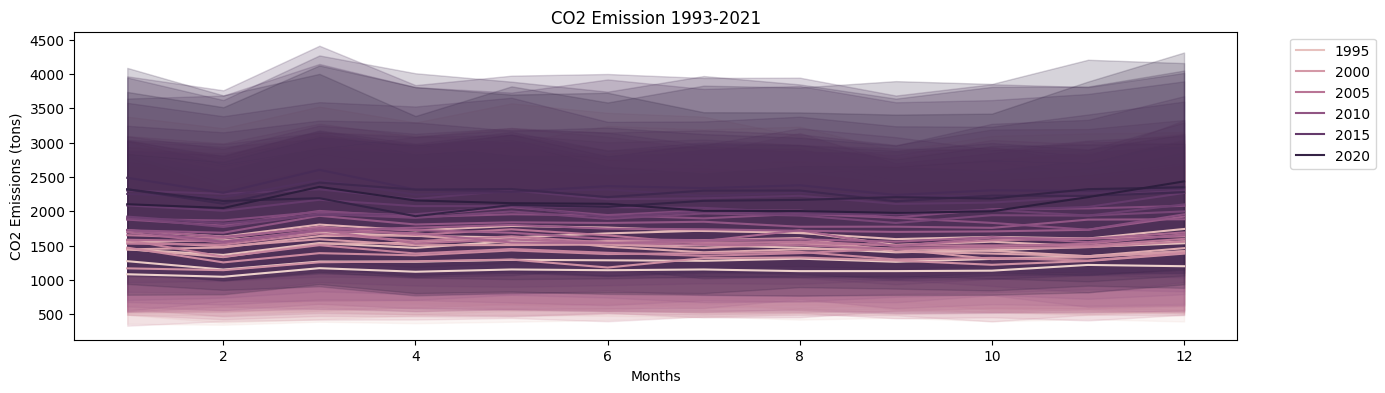

In [53]:
plt.figure(figsize=(15, 4))
sns.lineplot(co_train,
             x="month",
             y="emissions_tons",
             hue="year")

plt.title("CO2 Emission 1993-2021")
plt.legend(bbox_to_anchor=(1.04, 1), loc=2)
plt.xlabel("Months")
plt.ylabel("CO2 Emissions (tons)")